In [1]:
"""Used the following website to help with reading CSV files: 
https://www.geeksforgeeks.org/python/how-to-read-from-a-file-in-python/"""

import csv 

#getting quaternino data from first IMU sensor

with open("Sanity_Check_IMU_1.csv", newline='') as csvfile:

    csvreader = csv.reader(csvfile, delimiter='\t')
    sensor1 = []
    for row in csvreader:
        sensor1.append(row)

#only getting from the third row onwards (first rows are header, serial number etc.)    
sensor_1_clean_data = sensor1[3:]

In [2]:
#getting quaternion data from second IMU sensor

with open("Sanity_Check_IMU_2.csv", newline='') as csvfile:

    csvreader = csv.reader(csvfile, delimiter='\t')
    sensor2 = []
    for row in csvreader:
        sensor2.append(row)
        
sensor_2_clean_data = sensor2[3:]

In [3]:
import numpy as np

#function for multiplying two quaternions
def multiply_quaternions(q1,q2):
    w1,x1,y1,z1 = q1
    w2,x2,y2,z2 = q2

    return[
        w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2,
        w1 * w2 + x1 * w2 + y1 * z2 - z1 * y2,
        w1 * y2 - x1 * z2 + y1 * w2 + z1 * x2,
        w1 * z2 + x1 * y2 - y1 * x2 + z1 * w2
    ]

def quaternion_to_angle(sensor_array_1, sensor_array_2):

    angles_from_quaternions = []
    counter = 0

    for i in sensor_array_1:
        w1,x1,y1,z1 = float(i[1]), float(i[2]),float(i[3]), float(i[4])
        q1_conjugate = [w1, -x1, -y1, -z1]
        angle_calculated = False
        
        while angle_calculated == False and counter <len(sensor_array_2):
            k = sensor_array_2[counter]
            w2,x2,y2,z2 = float(k[1]), float(k[2]), float(k[3]), float(k[4])
            q2 = [w2, x2,y2,z2]

            #q_relative is the conjugate * q2
            q_relative = multiply_quaternions(q1_conjugate, q2) 
            
            #calculating angle from q_relative
            theta = 2 * np.arccos(q_relative[0])
            theta_deg = theta * (180/np.pi)

            angles_from_quaternions.append([180 - theta_deg] + [k[0]]) #180 - theta because sensors were inverted i think
            counter+=1
            angle_calculated = True
    
    
    return angles_from_quaternions


In [4]:
angles_with_timestamps = quaternion_to_angle(sensor_2_clean_data, sensor_1_clean_data)

angles = []
timestamps = []

for i in angles_with_timestamps:
    angles.append(i[0])
    timestamps.append(i[1])

In [5]:
import re

#function to get the visibility value from a Landmark string from CSV file
def get_visibility(landmark):
    visibility = re.search(r'visibility=([0-9.]+)', landmark)
    vis_value = visibility.group(1)
    return float(vis_value)

In [6]:
#Retrieving angles from CV results
import datetime

with open("Sanity_Check_CV.csv", newline='') as csvfile:

    csvreader = csv.reader(csvfile)

    computer_vision_results = []

    for row in csvreader:
        try:
            
            #getting the landmarks of shoulder, elbow, wrist (in string)
            shoulder_landmark = row[-24]
            elbow_landmark = row[-22]
            wrist_landmark = row[-20]

            #getting the visibility value of each landmark
            vis_shoulder = get_visibility(shoulder_landmark)
            vis_elbow = get_visibility(elbow_landmark)
            vis_wrist = get_visibility(wrist_landmark)
           
            
            #only adding the angles from CV results that are inbetween the time stamps of the quaternion data
            if datetime.datetime.strptime(row[0], '%Y-%m-%d %H:%M:%S.%f') > datetime.datetime.strptime(timestamps[0], '%m/%d/%Y %H:%M:%S.%f') and datetime.datetime.strptime(row[0], '%Y-%m-%d %H:%M:%S.%f') < datetime.datetime.strptime(timestamps[-1], '%m/%d/%Y %H:%M:%S.%f'):
                
                #if visbility value of shoulder, elbow and wrist are above threshold, then add the data points
                if vis_shoulder > 0.1 and vis_elbow > 0.1 and vis_wrist > 0.1:
                    computer_vision_results.append([row[-3]] + [row[0]]) #the third last column is angle, first column is timestamp
                else:
                    pass
            else:
                pass
        except:
            pass


In [7]:
CV_angles = []
CV_time_stamps = []
for i in computer_vision_results:
    CV_angles.append(float(i[0]))
    CV_time_stamps.append(i[1])

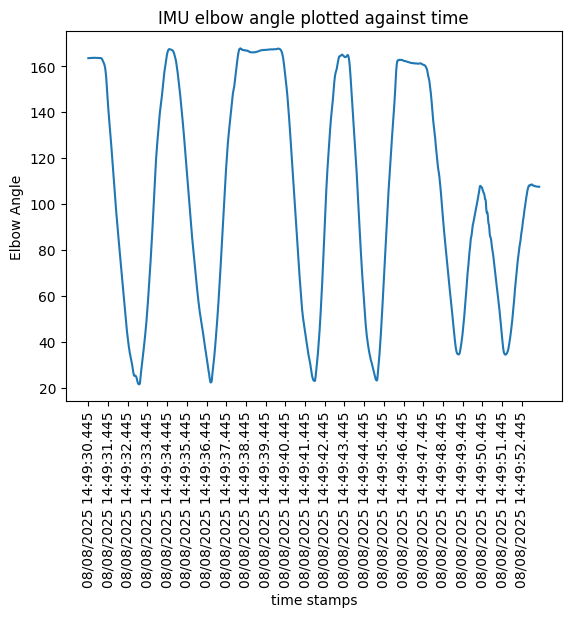

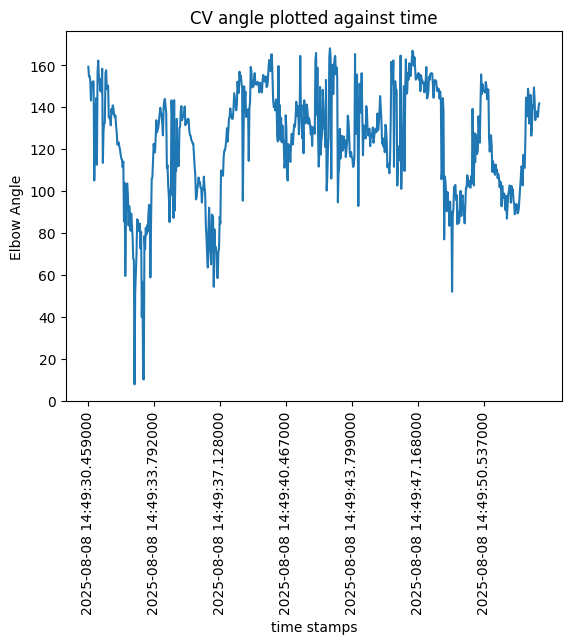

In [16]:
#Graphing results

import matplotlib.pyplot as plt

plt.plot(timestamps, angles)
plt.xlabel("time stamps")

#too many xlables, reduced to 1 in 10
x_index = [i for i in range(len(timestamps)) if i % 100 == 0]
x_labels = [timestamps[i] for i in x_index]
plt.xticks(x_index, x_labels, rotation=90)

plt.ylabel("Elbow Angle")
plt.title("IMU elbow angle plotted against time")
plt.show()

plt.plot(CV_time_stamps, CV_angles)
plt.xlabel("time stamps")

x_index = [i for i in range(len(CV_time_stamps)) if i % 100 == 0]
x_labels = [CV_time_stamps[i] for i in x_index]
plt.xticks(x_index, x_labels, rotation=90)


plt.ylabel("Elbow Angle")
plt.title("CV angle plotted against time")
plt.show()

#add code to plot CV angle results next to quaternion angle results

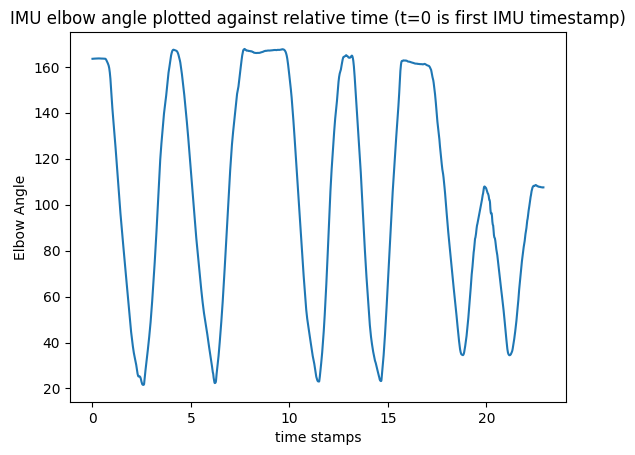

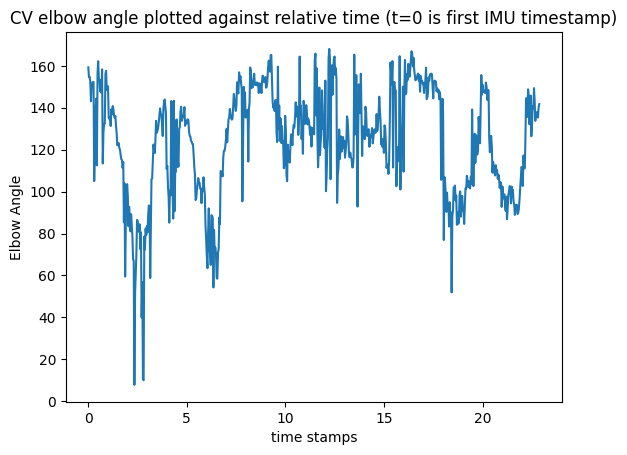

In [10]:
#converting IMU sensor and CV sensor timestamps into datetime format


#CV timestamps into datetime
CV_time_stamps_datetime = []

for i in CV_time_stamps:
    date_time = datetime.datetime.strptime(i, "%Y-%m-%d %H:%M:%S.%f")
    CV_time_stamps_datetime.append(date_time)

#print("CV timestamps in datetime", CV_time_stamps_datetime)


#IMU timestamps into datetime
IMU_time_stamps_datetime = []

for i in timestamps:
    date_time = datetime.datetime.strptime(i, "%m/%d/%Y %H:%M:%S.%f")
    IMU_time_stamps_datetime.append(date_time)

#print("IMU timestamps in datetime", IMU_time_stamps_datetime)


#calculating relative time for CV and IMU timestamps

t0 = IMU_time_stamps_datetime[0] #t0 will be the first timestamp from the IMU sensor (ground truth)

relative_time_CV = [] 
for i in CV_time_stamps_datetime:
    rel_time = i - t0
    relative_time_CV.append(rel_time.total_seconds())

relative_time_IMU = []
for i in IMU_time_stamps_datetime:
    rel_time = i - t0
    relative_time_IMU.append(rel_time.total_seconds())


#plot of relative time IMU
plt.plot(relative_time_IMU, angles)
plt.xlabel("time stamps")
plt.ylabel("Elbow Angle")
plt.title("IMU elbow angle plotted against relative time (t=0 is first IMU timestamp)")
plt.show()

#plot of relative time CV
plt.plot(relative_time_CV, CV_angles)
plt.xlabel("time stamps")
plt.ylabel("Elbow Angle")
plt.title("CV elbow angle plotted against relative time (t=0 is first IMU timestamp)")
plt.show()

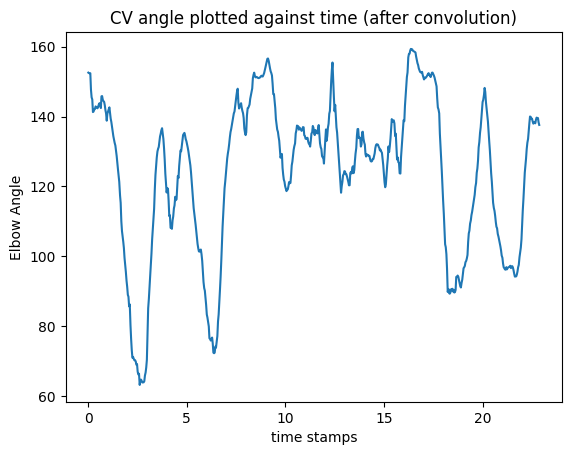

In [18]:
def smooth_signal(angles, window_size):
    smoothed_signal = []
    half = window_size // 2
    for i in range(0, len(angles)):
        if i - half < 0:
            angles_to_avg = angles[0: i + half]
            angles_avg = sum(angles_to_avg) / len(angles_to_avg)
            smoothed_signal.append(angles_avg)
        else:
            angles_to_avg = angles[i - half: i + half + 1] #python slicing is not inclusive so added +1
            angles_avg = sum(angles_to_avg) / len(angles_to_avg)
            smoothed_signal.append(angles_avg)        
    return smoothed_signal

x = smooth_signal(CV_angles, 13)

plt.plot(relative_time_CV, x)
plt.xlabel("time stamps")

plt.ylabel("Elbow Angle")
plt.title("CV angle plotted against time (after convolution)")
plt.show()

1912.5460939179154


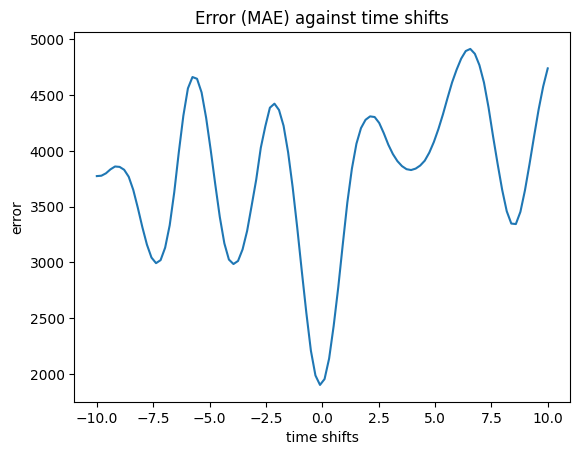

1806.1087859356032


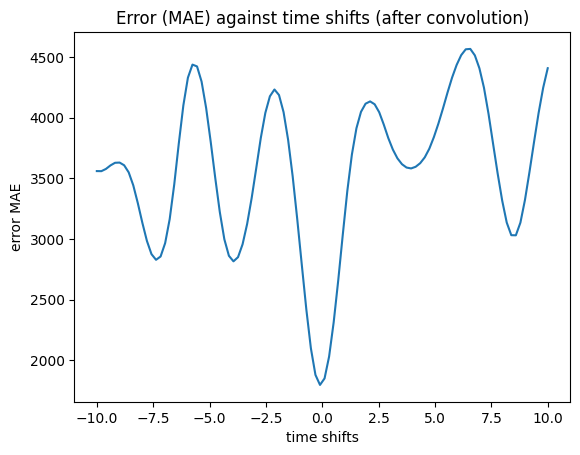

In [19]:
"""CV angles interpolated on IMU time axis. Each angle coincides with a relative 
time frame from IMU time axis"""

#Calculating MSE of time shift 0 (original time)
CV_interp = np.interp(relative_time_IMU, relative_time_CV, CV_angles)
MSE = np.mean((CV_interp - angles) ** 2)
print(MSE) 

def time_shift_errors(lower_bound, upper_bound, number_of_samples, cv_angles):
    #time shift
    time_shifts = np.linspace(lower_bound,upper_bound,number_of_samples)

    MSE_time_shifts = []
    errors_seperated = []
    time_shifts_seperated = []

    for i in time_shifts:
    
        #add time shift to each time value
        time_shifted = [i + time for time in relative_time_CV]
        
        #intersection time range where both have data
        time_shifted_intersection = [time for time in time_shifted 
                                    if time > relative_time_IMU[0] and time < relative_time_IMU[-1]]
        
        #intersection angle range where both have data
        CV_angles_trimmed = [angle for time, angle in zip(time_shifted, cv_angles) 
        if time > relative_time_IMU[0] and time < relative_time_IMU[-1]]

        #interpolate computer vision angle and time onto IMU time
        CV_interp = np.interp(relative_time_IMU, time_shifted_intersection, CV_angles_trimmed)
        
        MSE = np.mean((CV_interp - angles) ** 2)

        MSE_time_shifts.append([MSE, i])
        errors_seperated.append(MSE)
        time_shifts_seperated.append(i)
    
    return MSE_time_shifts, errors_seperated, time_shifts_seperated


#getting time shifts and errors into seperate arrays from MSE_time_shifts array
MSE_Total, errors_seperated, time_shifts_seperated = time_shift_errors(-10,10,100,CV_angles)

plt.plot(time_shifts_seperated, errors_seperated)
plt.title("Error (MAE) against time shifts")
plt.xlabel("time shifts")
plt.ylabel("error")
plt.show()

CV_interp = np.interp(relative_time_IMU, relative_time_CV, x)
MSE = np.mean((CV_interp - angles) ** 2)
print(MSE) 

MSE_Total, errors_seperated, time_shifts_seperated = time_shift_errors(-10,10,100, x)
#getting time shifts and errors into seperate arrays from MSE_time_shifts array

plt.plot(time_shifts_seperated, errors_seperated)
plt.title("Error (MAE) against time shifts (after convolution)")
plt.xlabel("time shifts")
plt.ylabel("error MAE")
plt.show()